In [1]:
import datetime
from tqdm import tqdm
now = datetime.datetime.now()
print now.year, now.month, now.day, now.hour, now.minute, now.second

2018 2 22 8 42 30


In [2]:
from sklearn.datasets.base import Bunch

In [12]:
dd = {123: Bunch(seq=[1,1,4,5,6], info=['M', 52]),
      456: Bunch(seq=[2,1,4,5,6], info=['M', 52]),
      678: Bunch(seq=[3,1,4,5,6], info=['M', 52]),
      999: Bunch(seq=[4,1,4,5,6], info=['M', 52]),}

In [43]:
import multiprocessing as mp
import numpy as np
from multiprocessing import Manager

def f(i, shared_arg=None):
    return 2*np.array(shared_arg[i].seq)

manager = Manager()
shared_dict = manager.dict(dd)
pool = mp.Pool(4)

results = [pool.apply_async(f, [i, shared_dict]) for i in [123, 456, 678, 999]]
results = [p.get() for p in results]
results

[array([ 2,  2,  8, 10, 12]),
 array([ 4,  2,  8, 10, 12]),
 array([ 6,  2,  8, 10, 12]),
 array([ 8,  2,  8, 10, 12])]

Process PoolWorker-20:
Process PoolWorker-21:
Process PoolWorker-22:
Traceback (most recent call last):
Process PoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/samu/miniconda2/lib/python2.7/multip

In [6]:
import pandas as pd
from __future__ import division

In [24]:
df = pd.read_csv('../tmp/dump_class_0.csv', header=0)
df.head()

,PTNT_ID
0,2917138437
1,2644508681
2,3505389578
3,2453667855
4,3314548753


In [85]:
n_jobs = 32

splits = np.array_split(df.values, n_jobs)

In [86]:
ss[0]

array([[2917138437],
       [2644508681],
       [3505389578],
       ...,
       [5105666806],
       [4600253182],
       [ 727862015]])

In [30]:
df.shape

(253180, 1)

In [7]:
import cPickle as pkl

# pp = pkl.load(open('../tmp/dump_class_0__raw_data_.pkl', 'rb'))

In [8]:
import os
mbs_files = filter(lambda x: x.startswith('MBS'), os.listdir('../../../data/'))
print(mbs_files)

['MBS_SAMPLE_10PCT_2014.csv', 'MBS_SAMPLE_10PCT_2010.csv', 'MBS_SAMPLE_10PCT_2012.csv', 'MBS_SAMPLE_10PCT_2008.csv', 'MBS_SAMPLE_10PCT_2009.csv', 'MBS_SAMPLE_10PCT_2013.csv', 'MBS_SAMPLE_10PCT_2011.csv']


In [15]:
___MBS_FILES_DICT__ = dict()
for mbs in mbs_files:
    mbs = os.path.join('..','..','..','data', mbs)
    ___MBS_FILES_DICT__[mbs] = pd.read_csv(mbs, header=0,
                                           usecols=['PIN', 'ITEM', 'DOS'])
    dd = ___MBS_FILES_DICT__[mbs]
    break

In [16]:
imap = pd.read_csv('../data/imap.tsv', sep='\t', header=0,
                   usecols=['ITEM', 'BTOS'])

In [23]:
# dd.join(imap, on='ITEM', how='left')
cc = pd.merge(dd, imap, how='left', on='ITEM')
cc.head()

,PIN,DOS,ITEM,BTOS
0,1779689312,14JUL2014,23,101
1,7359101341,08OCT2014,23,101
2,8948401274,25DEC2014,10991,1100
3,6745255963,03JUL2014,23,101
4,4116763637,04OCT2014,302,200


In [25]:
dd.shape

(47166827, 3)

In [18]:
dd.columns

Index([u'PIN', u'DOS', u'ITEM'], dtype='object')

In [56]:
mbs_dd = ___MBS_FILES_DICT__

In [ ]:
raw_data = dict()

In [103]:
split = set(splits[0].ravel())

In [197]:
import time

In [199]:
import warnings
warnings.filterwarnings('ignore')

In [200]:
t1 = time.time()
raw_data = dict()

# Pre-filter: keep only the elements of mbs_dd that are in the current split
# this helps in reducing the time of the next step
small_mbs_dd = dict()
for k in tqdm(sorted(mbs_dd.keys())):
    # keep only a subset of the full MBS data
    small_mbs_dd[k] = mbs_dd[k].loc[mbs_dd[k]['PIN'].isin(split)]
    # change format to the right datetime format (this is gonna be useful later)
    small_mbs_dd[k].loc[:,'DOS'] = pd.to_datetime(small_mbs_dd[k]['DOS'], format='%d%b%Y')    
    # and sort by date
    small_mbs_dd[k].sort_values(by='DOS', inplace=True)

# Now track down each patient in the reduced MBS files
for s in tqdm(split):
    tmp = pd.DataFrame(columns=['PIN', 'DOS', 'SPR_RSP'])
    for k in sorted(mbs_dd.keys()):
        tmp = pd.concat((tmp, small_mbs_dd[k].loc[small_mbs_dd[k]['PIN'] == s]))
        
    # evaluate the first order difference and convert each entry in days
    timedeltas = map(lambda x: pd.Timedelta(x).days, tmp['DOS'].values[1:] - tmp['DOS'].values[:-1])
    # then build the sequence as ['exam', idle-days, 'exam', idle-days, ...]
    raw_data[s] = flatten([[str(spr_rsp), dt] for spr_rsp, dt in zip(tmp['SPR_RSP'].values, timedeltas)])
    raw_data[s].append(str(tmp['SPR_RSP'].values[-1]))
    
t2 = time.time()
print(t2-t1)

100%|██████████| 7912/7912 [02:08<00:00, 61.80it/s]

242.623284817


In [208]:
import multiprocessing as mp

In [209]:
mp.pool.ThreadPool()

In [210]:
!hostname

megazord


In [211]:
os.name

'posix'

In [212]:
dd = pkl.load(open('../tmp/dump_class_0__raw_data_.pkl','rb'))

In [213]:
raw_data = dd['raw_data']

In [224]:
from collections import Counter
Counter(raw_data[9061269504][::2])

Counter({10: 2,
         21: 105,
         32: 1,
         47: 8,
         51: 2,
         54: 5,
         90: 4,
         93: 14,
         104: 12,
         117: 29,
         130: 28,
         186: 2,
         448: 2,
         550: 8})

<Container object of 3 artists>

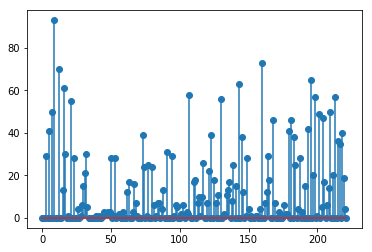

In [225]:
plt.stem(raw_data[9061269504][1::2])

In [216]:
import matplotlib.pyplot as plt
%matplotlib inline

In [221]:
np.arange(1, 11)[1::2]

array([ 2,  4,  6,  8, 10])

In [226]:
del dd